# Clustering Model Selection

We run a handful of clustering algorithms and hyperparameter combinations on a representative chunk of our dataset and pick the 'best'.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('../data/features/merged.csv')

## Create training data
### ... by filtering columns

For model selection, we drop all demographic breakdown columns, keeping the total counts of each type.

In [3]:
demo_columns = ['COMPLAINTS_BLACK','COMPLAINTS_HISPANIC','COMPLAINTS_WHITE','ISR_BLACK','ISR_WHITE','ISR_HISPANIC','UOF_HISPANIC','UOF_BLACK','UOF_WHITE','CENSUS_WHITE','CENSUS_BLACK','CENSUS_HISPANIC','CENSUS_MEDIAN INCOME', 'CENSUS_TOTAL POP']
training_data = data.drop(demo_columns, axis=1)

### .. by aggregating rows

For model selection, since we're eventually clustering by beat, we'll aggregate by summing all years together.


In [4]:
training_data = training_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.sum).reset_index(drop=True)

## Preprocess / Transform Data

In [5]:
from sklearn.preprocessing import StandardScaler
# Normalize columns
scaler = StandardScaler()
scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data),\
    columns=training_data.columns)

In [7]:
# Do PCA
from util_clustering import generate_pca_data
n_features = scaled_training_data.shape[1]
pca_training_data, pca = generate_pca_data(scaled_training_data, n_features)

## Peek at PCA

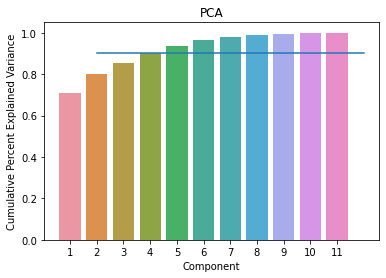

In [8]:
pca_analysis_df = pd.DataFrame({"evr":pca.explained_variance_ratio_,
                      "component": np.arange(1, pca.n_components_+1)}) \
            .assign(cum_evr = lambda x: x.evr.cumsum())
plt = sns.barplot(x="component",y="cum_evr", data=pca_analysis_df)
plt = sns.lineplot(x=pca_analysis_df.component, y=.9)
plt.set(title="PCA", xlabel="Component", ylabel="Cumulative Percent Explained Variance");

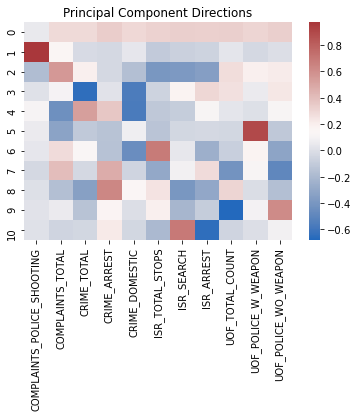

In [9]:
palette = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(pca.components_, cmap=palette, xticklabels=training_data.columns).set(title='Principal Component Directions');


From this, it looks like we can try clustering on the first 2, 4, 6 components to get 80%, 90% and 95% of the variance. 

## Pick Hyperparameters

### Number of a-priori clusters

In [10]:
# There are 272 police beats, 50 wards, 26 districts, 61 zips, 77 community areas.
param_n_clusters = [2,3,4,5,7,10,20,25,50,80]

### Number of neighbors

In [11]:
# Allow the number of neighbors to correspond to cluster sizes 
n_beats = scaled_training_data.shape[0]
param_n_neighbors = [round(np.ceil(n_beats / c)) for c in param_n_clusters]

### DBSCAN epsilon : defines neighborhood size

In [12]:
def generate_epsilons(dataset, num=6):
    """
        Return log-spaced range of distances
        based on min and max distances represented in dataset.
    """
    # Find maximum possible distance.
    data_ranges = dataset.agg([min,max])
    data_ranges = data_ranges.loc['max'] - data_ranges.loc['min']
    data_range_diag = np.sqrt(np.mean(data_ranges * data_ranges))
    # Find absolute minimum and maximum distances between points in data set
    min_dist = 9999
    max_dist = 0
    for row1 in dataset.iterrows():
        for row2 in dataset.iterrows():
            dist = 0
            for col in dataset.columns:
                dist += (row1[1][col] - row2[1][col])**2
            dist = np.sqrt(dist / len(dataset.columns))
            if row1[0] != row2[0]:
                min_dist = min(dist, min_dist)
                max_dist = max(dist, max_dist)
    # print(f'Data range: {data_range_diag:.2e}, Minimum distance: {min_dist:.2e}, Maximum distance: {max_dist:.2e}')
    return np.geomspace(min_dist*2, max_dist/2, num=num)

## Run Grid Search

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from util_clustering import grid_search_clustering
def hyperparameter_search(dataset):
    params_km = {'n_clusters':param_n_clusters}
    params_hagg = {'n_clusters':param_n_clusters, \
                    'affinity':['euclidean','cosine'], \
                    'linkage':['complete','average','single']}
    params_dbscan = {'eps':generate_epsilons(dataset), \
                    'min_samples':param_n_neighbors, \
                    'metric':['euclidean','cosine']}
    params_gauss = {'n_components':param_n_clusters, \
                    'n_init':[10]}
    params_spectral = [{'affinity': ['rbf'], \
                            'n_clusters':param_n_clusters}, \
                        {'affinity': ['nearest_neighbors'], \
                            'n_clusters':param_n_clusters, \
                            'n_neighbors':param_n_neighbors}]

    km_result = grid_search_clustering(KMeans(), \
        ParameterGrid(params_km), dataset, 'inertia_')

    hagg_result = grid_search_clustering(AgglomerativeClustering(), \
        ParameterGrid(params_hagg), dataset)

    dbscan_result = grid_search_clustering(DBSCAN(), \
        ParameterGrid(params_dbscan), dataset)

    gauss_result = grid_search_clustering(GaussianMixture(), \
        ParameterGrid(params_gauss), dataset, 'bic')

    spectral_result = grid_search_clustering(SpectralClustering(), \
        ParameterGrid(params_spectral), dataset)

    return pd.concat([km_result, hagg_result, dbscan_result, gauss_result, spectral_result])


In [77]:
# Run clusterings on all data in feature space
scaled_training_data_grid_results = hyperparameter_search(scaled_training_data)

# Make reduced-dimensionality dataframes
pca2_training_data, _ = generate_pca_data(scaled_training_data, 2)
pca4_training_data, _ = generate_pca_data(scaled_training_data, 4)
pca6_training_data, _ = generate_pca_data(scaled_training_data, 6)

# Run clusterings on dimension-reduced data in PCA space
pca2_data_grid_results = hyperparameter_search(pca2_training_data)
pca4_data_grid_results = hyperparameter_search(pca4_training_data)
pca6_data_grid_results = hyperparameter_search(pca6_training_data)



 0:00:00.004368
Training DBSCAN with: {'eps': 1.6998857175357442, 'metric': 'cosine', 'min_samples': 39}
Training Time Elapsed: 0:00:00.004153
Training DBSCAN with: {'eps': 1.6998857175357442, 'metric': 'cosine', 'min_samples': 28}
Training Time Elapsed: 0:00:00.003700
Training DBSCAN with: {'eps': 1.6998857175357442, 'metric': 'cosine', 'min_samples': 14}
Training Time Elapsed: 0:00:00.004362
Training DBSCAN with: {'eps': 1.6998857175357442, 'metric': 'cosine', 'min_samples': 11}
Training Time Elapsed: 0:00:00.004363
Training DBSCAN with: {'eps': 1.6998857175357442, 'metric': 'cosine', 'min_samples': 6}
Training Time Elapsed: 0:00:00.004698
Training DBSCAN with: {'eps': 1.6998857175357442, 'metric': 'cosine', 'min_samples': 4}
Training Time Elapsed: 0:00:00.004523
Training DBSCAN with: {'eps': 3.981874525292634, 'metric': 'euclidean', 'min_samples': 136}
Training Time Elapsed: 0:00:00.005068
Training DBSCAN with: {'eps': 3.981874525292634, 'metric': 'euclidean', 'min_samples': 91}
Tra

In [78]:
# Combine all grid search results
all_grid_results = pd.concat([scaled_training_data_grid_results, pca2_data_grid_results, pca4_data_grid_results, pca6_data_grid_results], keys = ['scaled','pca2','pca4','pca6']) \
    .reset_index(level=0).rename(columns={'level_0':'Dataset'})

## Analyze Model Performance

### Pick best within KMeans

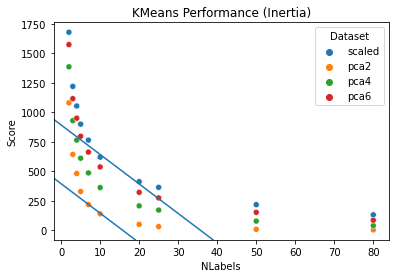

In [261]:
k_means_grid_results = all_grid_results.loc[all_grid_results['Model']=='KMeans'] \
    .assign(MAJORITY = lambda x: largest_cluster_size(x))
g = sns.scatterplot(data=k_means_grid_results, x='NLabels', y='Score', hue='Dataset')
g.axline(xy1=(7,219), slope=-250/10)
g.axline(xy1=(10,642), slope=-250/10)
g.set(title="KMeans Performance (Inertia)");

This suggests that the optimal KMeans model uses 7 clusters if using the PCA data and 10 clusters if using the scaled data.

In [262]:
best_kmeans = k_means_grid_results.loc[k_means_grid_results['NLabels'] == 7].head(1)
best_kmeans_params = best_kmeans['Params'].to_numpy()[0]


### Pick best within Gaussian MM

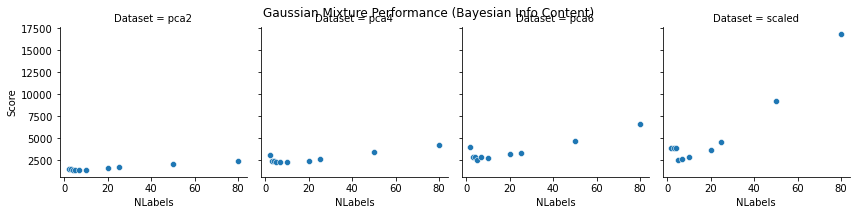

In [263]:
gauss_grid_results = all_grid_results.loc[all_grid_results['Model']=='GaussianMixture'] \
    .assign(MAJORITY = lambda x: largest_cluster_size(x)) \
    .groupby('Dataset').apply(lambda x: x.sort_values(['NLabels'])) \
    .assign(GRAD_BIC = lambda x: x['Score'].diff())
g = sns.FacetGrid(data=gauss_grid_results, col='Dataset')
g.map(sns.scatterplot, 'NLabels', 'Score')
g.fig.suptitle("Gaussian Mixture Performance (Bayesian Info Content)");

This plot is messier, but we can say models with 7 and 10 clusters have comparable BIC scores.

In [264]:
best_gauss = gauss_grid_results.loc[gauss_grid_results['NLabels'] == 7].head(1)
best_gauss_params = best_gauss['Params'].to_numpy()[0]


### Pick Best DBSCAN

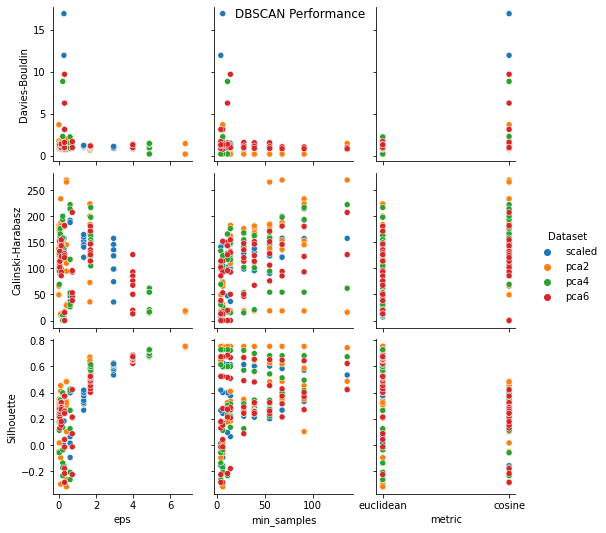

In [108]:
metric_cols = ["Davies-Bouldin","Calinski-Harabasz","Silhouette"]
dbscan_grid_results = all_grid_results.loc[all_grid_results['Model']=='DBSCAN'].reset_index(drop=True)
dbscan_params_df = pd.json_normalize(dbscan_grid_results['Params'])
dbscan_grid_results = pd.merge(dbscan_grid_results, dbscan_params_df, how='inner',left_index=True,right_index=True)
g = sns.pairplot(data=dbscan_grid_results, x_vars=['eps','min_samples','metric'], y_vars=metric_cols, hue='Dataset')
g.fig.suptitle('DBSCAN Performance');

It looks like the scores are sort of constant with min_samples, and I think we should use euclidean distance not cosine. So lastly silouhette and davies get better with eps and c-h sort of gets worse, but is average. So lets pick the biggest eps.

In [251]:
def largest_cluster_size(grid_results):
    freqs = [] 
    for row in grid_results.itertuples():
        unique, freq = np.unique(row.Labels, return_counts=True)
        freqs.append(max(freq)/sum(freq))
    return pd.Series(freqs, name='MAJORITY')


In [275]:
# DBScan also puts things into mostly one cluster
best_dbscan = dbscan_grid_results.assign(MAJORITY = lambda x: largest_cluster_size(x)) \
    .loc[lambda x: (x['metric'] == 'euclidean') & (x['NLabels'] > 2) & (x['MAJORITY'] < .8)] \
    .sort_values('Silhouette',ascending=False).head(1)
best_dbscan_params = best_dbscan['Params'].to_numpy()[0]
best_dbscan_params


{'eps': 0.6100687982398104, 'metric': 'euclidean', 'min_samples': 4}

### Pick best Heirarchical

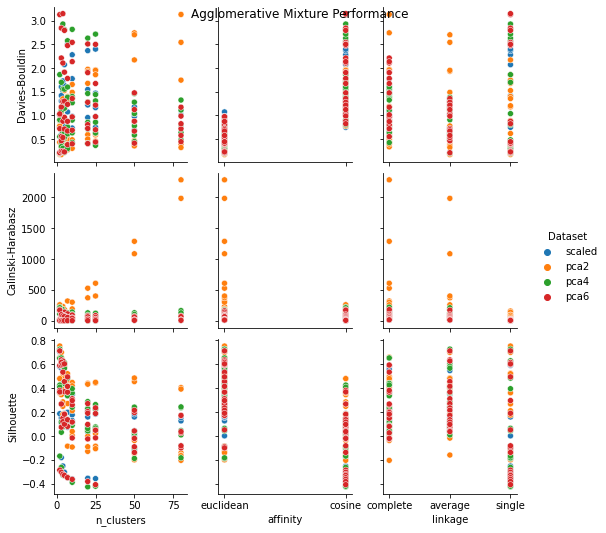

In [266]:
hagg_grid_results = all_grid_results.loc[all_grid_results['Model']=='AgglomerativeClustering'].reset_index(drop=True)
hagg_params_df = pd.json_normalize(hagg_grid_results['Params'])
hagg_grid_results = pd.concat([hagg_grid_results, hagg_params_df],axis=1)
g = sns.pairplot(data=hagg_grid_results, x_vars=['n_clusters','affinity','linkage'], y_vars=metric_cols, hue='Dataset')
g.fig.suptitle("Agglomerative Mixture Performance");

All metrics get better with fewer clusters and euclidean and affinity is sort of a wash.

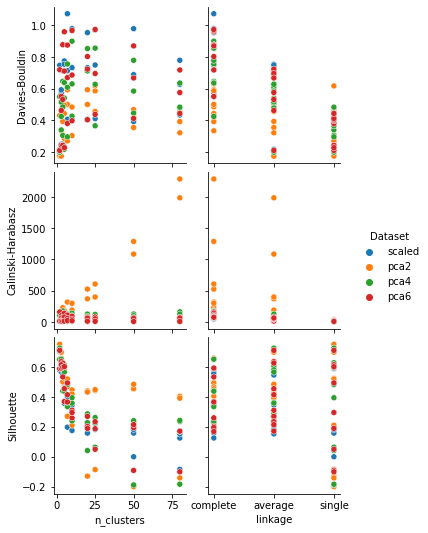

In [267]:
# Re-filter on euclidean
hagg_grid_results = hagg_grid_results.loc[hagg_grid_results['affinity'] == 'euclidean']
g = sns.pairplot(data=hagg_grid_results, x_vars=['n_clusters','linkage'], y_vars=metric_cols, hue='Dataset')

It looks like maybe the best linkage is from single.

In [268]:
# The heirarchical model tends to cluster almost everything into the same cluster
# So we'll pick one that actually distributes the values somewhat
best_hagg = hagg_grid_results.assign(MAJORITY = lambda x: largest_cluster_size(x)) \
    .loc[lambda x: x['MAJORITY'] < .8] \
    .sort_values('NLabels',ascending=True).head(1)
best_hagg_params = best_hagg['Params'].to_numpy()[0]
best_hagg_params

{'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 4}

### Pick best spectral

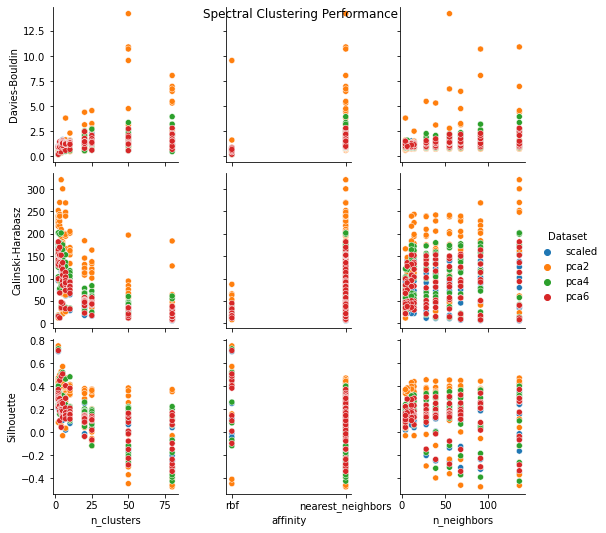

In [269]:
spectral_grid_results = all_grid_results.loc[all_grid_results['Model']=='SpectralClustering'].reset_index(drop=True)
spectral_params_df = pd.json_normalize(spectral_grid_results['Params'])
spectral_grid_results = pd.concat([spectral_grid_results, spectral_params_df],axis=1)
g = sns.pairplot(data=spectral_grid_results, x_vars=['n_clusters','affinity','n_neighbors'], y_vars=metric_cols, hue='Dataset')
g.fig.suptitle("Spectral Clustering Performance");

Increasing n_neighbors typically makes things worse. Rbf is better on average. Increasing n_clusters is unknown.

In [270]:
# Spectral also tends to put things into one group so pick something with some varaition

best_spectral = spectral_grid_results.assign(MAJORITY = lambda x: largest_cluster_size(x)) \
    .loc[lambda x: x['MAJORITY'] < .8] \
    .sort_values('Silhouette',ascending=False).head(1)
best_spectral_params = best_spectral['Params'].to_numpy()[0]
best_spectral_params

{'affinity': 'nearest_neighbors', 'n_clusters': 2, 'n_neighbors': 136}

## Compare Across Models

### Compare haow models did generally, and across datasets

/Users/eric/miniconda3/envs/mlpp/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


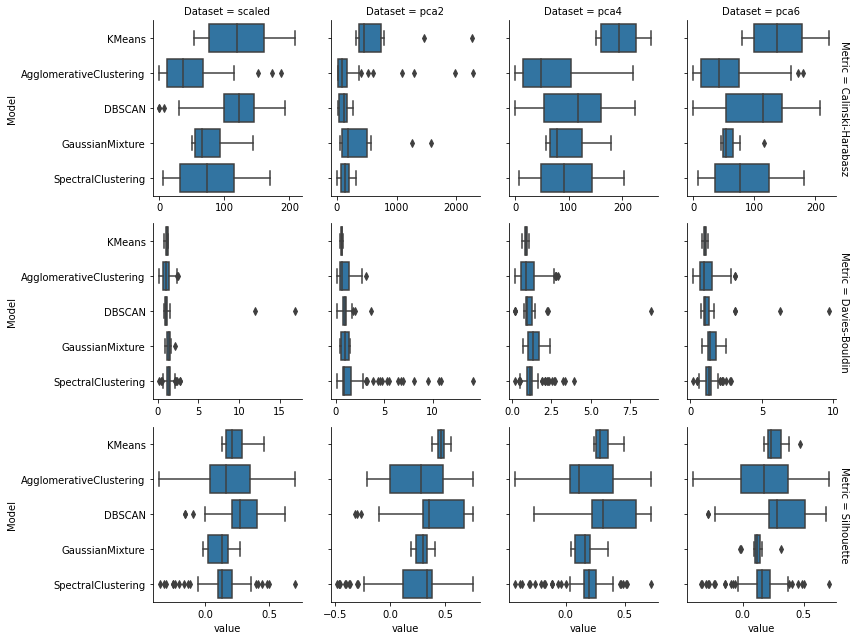

In [271]:
all_grid_results_melted = all_grid_results.drop(['Params','Time','NLabels','Labels','Score'],axis=1).melt(id_vars=['Dataset','Model'], var_name='Metric')
g = sns.FacetGrid(data=all_grid_results_melted, row='Metric', col='Dataset', sharex=False,margin_titles=True)
g.map(sns.boxplot, 'value', 'Model')

### Compare how 'best' of each model did

Text(0.5, 0.98, 'Best Models Scores')

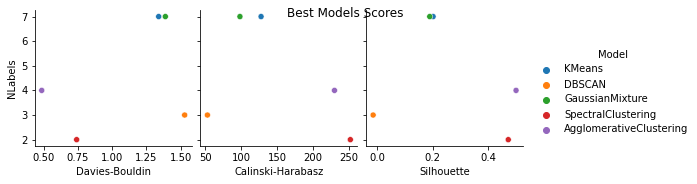

In [276]:
g = sns.pairplot(data=best_models, x_vars=metric_cols, y_vars=['NLabels'], hue='Model')
g.fig.suptitle('Best Models Scores')

In [277]:
best_models = pd.concat([best_kmeans, best_dbscan, best_gauss, best_spectral, best_hagg]) \
    .assign(DBRank = lambda x: x['Davies-Bouldin'].rank(),
            CHRank = lambda x: x['Calinski-Harabasz'].rank(),
            SRank = lambda x: x['Silhouette'].rank(ascending=False), 
            TotalRank = lambda x: x['DBRank'] + x['CHRank'] + x['SRank']) \
    .loc[:, ['Dataset', 'Model', 'Params', 'Calinski-Harabasz',
       'Davies-Bouldin', 'Silhouette', 'NLabels', 'Labels', 'MAJORITY', 'TotalRank']]
best_models.sort_values('TotalRank')


,Dataset,Model,Params,Calinski-Harabasz,Davies-Bouldin,Silhouette,NLabels,Labels,MAJORITY,TotalRank
62,pca2,AgglomerativeClustering,"{'affinity': 'euclidean', 'linkage': 'complete...",229.802865,0.485827,0.499716,4,"[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, ...",0.653137,6.0
69,scaled,DBSCAN,"{'eps': 0.6100687982398104, 'metric': 'euclide...",36.723074,1.139797,0.013908,3,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",0.771218,9.0
120,pca2,SpectralClustering,"{'affinity': 'nearest_neighbors', 'n_clusters'...",251.852025,0.740765,0.471731,2,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, ...",0.505535,9.0
4,scaled,KMeans,{'n_clusters': 7},127.77592,1.339745,0.201338,7,"[1, 2, 2, 2, 0, 2, 4, 4, 1, 0, 5, 2, 4, 2, 2, ...",0.261993,10.0
"(pca2, 4)",pca2,GaussianMixture,"{'n_components': 7, 'n_init': 10}",98.418166,1.388387,0.189322,7,"[5, 5, 5, 5, 1, 5, 5, 5, 4, 1, 6, 5, 4, 5, 2, ...",0.586716,11.0


## In Conclusion

We could make the case that agglomerative clustering is the best. But the margin between the ranks is pretty small anyway. So we really don't have a good reason to pick one or the other.